##TEST#3



#1) LSTM을 이용한 Extruder 문제

Final 대체 프로젝트로도 제공 되었던 Extruder 데이터를 활용한 문제 입니다.

꼭 필요한 데이터 처리 과정중 어려운 부분의 코드는 제공해주었습니다.

노드의 수와 layer의 수의 제한은 없습니다. 대신 저와 똑같은 노드와 layer 수로 모델을 선정하지 마세요.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, TimeDistributed, Dropout
from keras import optimizers
from sklearn.metrics import mean_squared_error

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.random.set_seed(42)

df= pd.read_csv('/content/drive/MyDrive/test/extrusion.csv')
 
df.info()

columns =list(df.columns)
print(columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226536 entries, 0 to 226535
Columns: 470 entries, Datum to ST114_VARWdTensVis
dtypes: float64(468), int64(1), object(1)
memory usage: 812.3+ MB
['Datum', 'ST0_VARActAuftrag', 'ST110_VARExtr_0_HeizungZone_3_Regler_Y', 'ST110_VARExtr_0_HeizungZone_3_SollTemp', 'ST110_VARExtr_0_HeizungZone_4_Konfig', 'ST110_VARExtr_0_HeizungZone_4_Regler_X', 'ST110_VARExtr_0_HeizungZone_4_Regler_Y', 'ST110_VARExtr_0_HeizungZone_4_SollTemp', 'ST110_VARExtr_0_HeizungZone_5_Konfig', 'ST110_VARExtr_0_HeizungZone_5_Regler_X', 'ST110_VARExtr_0_HeizungZone_5_Regler_Y', 'ST110_VARExtr_0_HeizungZone_5_SollTemp', 'ST110_VARExtr_0_HeizungZone_6_Konfig', 'ST110_VARExtr_0_HeizungZone_6_Regler_X', 'ST110_VARExtr_0_HeizungZone_6_Regler_Y', 'ST110_VARExtr_0_HeizungZone_6_SollTemp', 'ST110_VARExtr_0_HeizungZone_7_Konfig', 'ST110_VARExtr_0_HeizungZone_7_Regler_X', 'ST110_VARExtr_0_HeizungZone_7_Regler_Y', 'ST110_VARExtr_0_HeizungZone_7_SollTemp', 'ST110_VARExtr_0_HeizungZon

In [ ]:
del df['Datum']
columns.remove('Datum')

Target_index의 column name은 ST110_VAREx_0_ReagelungEin 입니다.

In [ ]:
target_index = columns.index('ST110_VAREx_0_RegelungEin')
print(target_index)

156


In [ ]:
X = np.array(df)
Y = np.array(df.iloc[:,target_index])

print("X.shape: ", X.shape)
print("Y.shape: ", Y.shape)

X.shape:  (226536, 469)
Y.shape:  (226536,)


In [ ]:
null_row = []

for i in range(len(X)):
    for j in range(len(columns)):
        if pd.isnull(X[i,j]):
            null_row.append(i)

In [ ]:
null_row = sorted(list(set(null_row)))

print(null_row)
print(len(null_row))

[18398, 18399, 18400, 18454, 20979, 24019, 24035, 58210, 58211, 58212, 62021, 62022, 62023, 62024, 62025, 62026, 62027, 62028, 62029, 70978, 71524, 71576, 78210, 82932, 82933, 82934, 87052, 87053, 91158, 96208, 96209, 96210, 96211, 96212, 96213, 96214, 96215, 96216, 96217, 96218, 96219, 96220, 96221, 96222, 96223, 96224, 96225, 96226, 96227, 96228, 96229, 96230, 96231, 96232, 96233, 96234, 96235, 96236, 96237, 96238, 96239, 96240, 96241, 96242, 96243, 96244, 96245, 96246, 96247, 96248, 96249, 96250, 96251, 96252, 96253, 96254, 96255, 96256, 96257, 96258, 96259, 96260, 96261, 96262, 96263, 96264, 96265, 96266, 96267, 96268, 96269, 96270, 96271, 96272, 96273, 96274, 96275, 96276, 96277, 96278, 96279, 96280, 96281, 96282, 96283, 96284, 96285, 96286, 96287, 96288, 96289, 96290, 96291, 96292, 96293, 96294, 96295, 96296, 96297, 96298, 96299, 96300, 96301, 96302, 96303, 96304, 96305, 96306, 96307, 96308, 96309, 96310, 96311, 96312, 96313, 96314, 96315, 96316, 96317, 96318, 96319, 96320, 96321

In [ ]:
seq_length = 50
predict_length = 10
input_columns = len(columns)

num_Data = 1

if null_row[0] - 1 > seq_length + predict_length:
    X0 = X[:null_row[0] - 1, :]
    Y0 = Y[:null_row[0] - 1]

for i in range(1, len(null_row)):
    if null_row[i] - null_row[i-1] - 1 > seq_length + predict_length:
        locals()['X{}'.format(num_Data)] = X[null_row[i-1] + 1 : null_row[i] - 1, :]
        locals()['Y{}'.format(num_Data)] = Y[null_row[i-1] + 1 : null_row[i] - 1]
        num_Data += 1

In [ ]:
def min_max_scaling(x):
    scaler=MinMaxScaler()
    x_np = np.asarray(x)
    x_np = scaler.fit_transform(x_np)
    return x_np

In [ ]:
selected_feature_idx = [130, 156, 157, 253, 274, 278, 288, 465]

x = min_max_scaling(X0[:, selected_feature_idx])


dataX = []
dataY = []
for i in range(0, len(Y0) - seq_length - predict_length + 1):
    _x = x[i : i + seq_length]
    _y = Y0[i + seq_length : i + seq_length + predict_length]
    dataX.append(_x)
    dataY.append(_y)
    

dataX = np.array(dataX)
dataY = np.array(dataY)
dataY=dataY.reshape(18338,10,1)

trainX, testX, trainY, testY = train_test_split(dataX,dataY,test_size=0.3,shuffle=False)


print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(12836, 50, 8)
(12836, 10, 1)
(5502, 50, 8)
(5502, 10, 1)


In [ ]:
select_columns = []
for i in selected_feature_idx:
  select_columns.append(columns[i])
select_columns

['ST110_VARExtr_3_HeizungZone_4_Regler_Y',
 'ST110_VAREx_0_RegelungEin',
 'ST110_VAREx_0_SDickeIst',
 'ST110_VAREx_2_Dos_5_Materialvorwahl',
 'ST110_VAREx_3_Dos_2_IstDurchsatz',
 'ST110_VAREx_3_Dos_2_SollAnteil',
 'ST110_VAREx_3_Dos_3_SollAnteil',
 'ST114_VARWdSpTens']

In [ ]:
model_rnn=keras.Sequential()
model_rnn.add(keras.layers.LSTM(64,activation='tanh',return_sequences=True,input_shape=(50,8)))
model_rnn.add(keras.layers.LSTM(32,activation='tanh',return_sequences=True))
model_rnn.add(keras.layers.LSTM(32,activation='tanh',return_sequences=False))
model_rnn.add(keras.layers.Dense(10,activation='sigmoid'))
model_rnn.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 64)            18688     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 32)            12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 10)                330       
Total params: 39,754
Trainable params: 39,754
Non-trainable params: 0
_________________________________________________________________


Callback은 반드시 써주세요.

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es=EarlyStopping(monitor='val_loss',min_delta=0,verbose=1,patience=5)
mc=ModelCheckpoint('best_rnn_model.h5',monitor='val_loss',mode='min',save_best_only=True)

model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['mse'])
history=model_rnn.fit(trainX,trainY,validation_split=0.2,epochs=10,callbacks=[es,mc],batch_size=32)

Epoch 1/10
321/321 [==============================] - 45s 75ms/step - loss: 0.3000 - mse: 0.0883 - val_loss: 0.1874 - val_mse: 0.0475
Epoch 2/10
321/321 [==============================] - 22s 70ms/step - loss: 0.1102 - mse: 0.0246 - val_loss: 0.1471 - val_mse: 0.0333
Epoch 3/10
321/321 [==============================] - 22s 70ms/step - loss: 0.0877 - mse: 0.0189 - val_loss: 0.1369 - val_mse: 0.0309
Epoch 4/10
321/321 [==============================] - 22s 70ms/step - loss: 0.0891 - mse: 0.0188 - val_loss: 0.1411 - val_mse: 0.0334
Epoch 5/10
321/321 [==============================] - 22s 70ms/step - loss: 0.0773 - mse: 0.0163 - val_loss: 0.1326 - val_mse: 0.0303
Epoch 6/10
321/321 [==============================] - 22s 69ms/step - loss: 0.0764 - mse: 0.0160 - val_loss: 0.1263 - val_mse: 0.0294
Epoch 7/10
321/321 [==============================] - 22s 70ms/step - loss: 0.0783 - mse: 0.0165 - val_loss: 0.1328 - val_mse: 0.0312
Epoch 8/10
321/321 [==============================] - 22s 70ms

[0.19274193048477173, 0.09450259804725647, 0.08527121692895889, 0.08204838633537292, 0.08128450065851212, 0.07936030626296997, 0.07997209578752518, 0.07718762010335922, 0.07605312019586563, 0.07633268088102341]


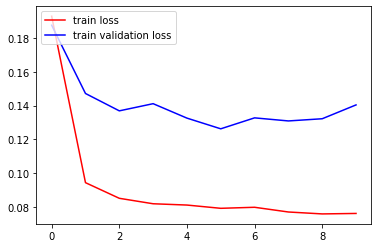

In [ ]:
print(history.history['loss'])
fig,loss_ax=plt.subplots()
loss_ax.plot(history.history['loss'],'r',label='train loss')
loss_ax.plot(history.history['val_loss'],'b',label='train validation loss')
loss_ax.legend(loc='upper left')

plt.show()

In [ ]:
model_rnn.load_weights('best_rnn_model.h5')
model_rnn.evaluate(testX,testY)

172/172 [==============================] - 3s 18ms/step - loss: 0.1451 - mse: 0.0338


[0.14505867660045624, 0.033846333622932434]

In [ ]:
y_predict=model_rnn.predict(testX)
predict=[]
for i in range(5502):
  predict.append(y_predict[i][0])

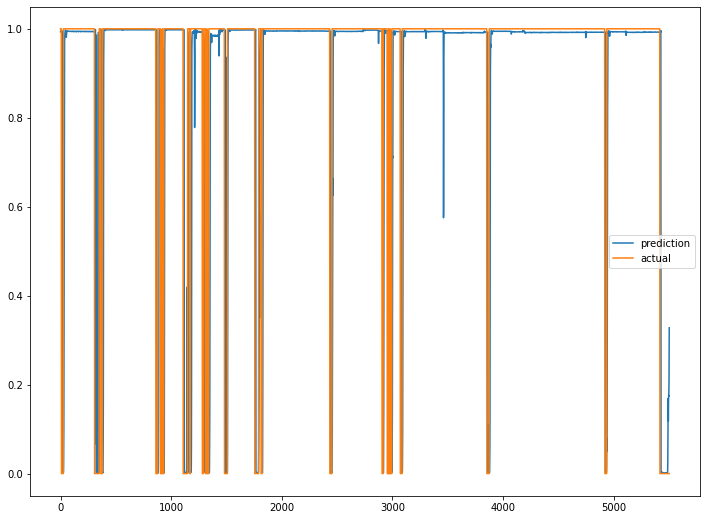

In [ ]:

plt.figure(figsize=(12, 9))
plt.plot(predict,label='prediction')
plt.plot(Y0[-5502:],label='actual')
plt.legend(loc='center right')
plt.show()

#2) 자동차 연비(MPG) 예측 문제

In [ ]:
import tensorflow as tf
from tensorflow import keras

dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [ ]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [ ]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [ ]:
dataset = dataset.dropna()

In [ ]:
origin = dataset.pop('Origin')

In [ ]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [ ]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [ ]:
train_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,28.0,4,90.0,75.0,2125.0,14.5,74,1.0,0.0,0.0
282,22.3,4,140.0,88.0,2890.0,17.3,79,1.0,0.0,0.0
69,12.0,8,350.0,160.0,4456.0,13.5,72,1.0,0.0,0.0
378,38.0,4,105.0,63.0,2125.0,14.7,82,1.0,0.0,0.0
331,33.8,4,97.0,67.0,2145.0,18.0,80,0.0,0.0,1.0


feature와 label 분리

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()

train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [ ]:
train_dataset.shape

(314, 9)

정규화하기 ( norm 함수를 사용)

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [ ]:
normed_train_data

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852
...,...,...,...,...,...,...,...,...,...
281,0.307270,0.044872,-0.521559,-0.000298,0.946772,0.843910,0.774676,-0.465148,-0.495225
229,1.483887,1.961837,1.972127,1.457223,-1.598734,0.299787,0.774676,-0.465148,-0.495225
150,-0.869348,-0.836932,-0.311564,-0.710099,-0.021237,-0.516397,-1.286751,-0.465148,2.012852
145,-0.869348,-1.076553,-1.151543,-1.169870,1.233589,-0.516397,-1.286751,-0.465148,2.012852


**해당 문제에서는 모델을 제공하지 않습니다.**

어떠한 모델을 사용하셔도 좋습니다. (FFNN등등)

하지만 2개 이상의 모델을 사용하시고 각 모델의 성능을 비교해 주세요.
(동일 모델에서 layer와 뉴런수를 조절하여 모델을 두개 만드는 것이 아닌, 만약 1번 모델을 FCNN을 사용했다면, 2번 모델은 FFNN이 아닌 다른 모델을 사용해 주세요.)

mae가 2.5 이하, mse가 6.5 이하가 되도록 모델 성능을 조절해 주세요.

In [ ]:
mc=ModelCheckpoint('best_ffnn_model.h5',monitor='mse',mode='min',save_best_only=True)
model_a=keras.Sequential([
                        keras.layers.Flatten(input_shape=normed_train_data.shape[1:]),
                        keras.layers.Dense(64,activation='relu'),
                        keras.layers.Dense(32,activation='relu'),
                        keras.layers.Dense(16,activation='relu'),
                        keras.layers.Dense(8,activation='relu'),
                        keras.layers.Dense(1)
])
model_a.compile(loss='mse',optimizer='adam',metrics=['mse','mae'])
model_a.fit(normed_train_data,train_labels,batch_size=1, epochs=50,callbacks=[mc])

Epoch 1/50
314/314 [==============================] - 1s 2ms/step - loss: 301.5292 - mse: 301.5292 - mae: 13.3384
Epoch 2/50
314/314 [==============================] - 0s 1ms/step - loss: 13.1685 - mse: 13.1685 - mae: 2.6949
Epoch 3/50
314/314 [==============================] - 0s 1ms/step - loss: 10.8798 - mse: 10.8798 - mae: 2.3946
Epoch 4/50
314/314 [==============================] - 0s 1ms/step - loss: 8.9820 - mse: 8.9820 - mae: 2.2201
Epoch 5/50
314/314 [==============================] - 0s 1ms/step - loss: 9.0730 - mse: 9.0730 - mae: 2.1358
Epoch 6/50
314/314 [==============================] - 0s 1ms/step - loss: 8.6499 - mse: 8.6499 - mae: 2.1199
Epoch 7/50
314/314 [==============================] - 0s 1ms/step - loss: 8.9320 - mse: 8.9320 - mae: 2.1158
Epoch 8/50
314/314 [==============================] - 0s 1ms/step - loss: 8.1775 - mse: 8.1775 - mae: 2.1539
Epoch 9/50
314/314 [==============================] - 1s 2ms/step - loss: 8.3950 - mse: 8.3950 - mae: 2.0833
Epoch 10/5

In [ ]:
model_a.load_weights('best_ffnn_model.h5')
model_a.evaluate(normed_test_data,test_labels)

3/3 [==============================] - 0s 4ms/step - loss: 6.3656 - mse: 6.3656 - mae: 1.9837


[6.365559101104736, 6.365559101104736, 1.9837207794189453]

In [ ]:
normed_train_data_s=np.array(normed_train_data)
normed_train_data_s=normed_train_data_s.reshape(314,9,1)
normed_test_data_s =np.array(normed_test_data)
normed_test_data_s=normed_test_data_s.reshape(78,9,1)

In [ ]:
mc_cnn=ModelCheckpoint('best_cnn_model.h5',monitor='mse',mode='min',save_best_only=True)
model_b=keras.Sequential([
                        keras.layers.Conv1D(filters=40,kernel_size=2,activation='relu',input_shape=normed_test_data_s.shape[1:]),
                        keras.layers.MaxPooling1D(pool_size=2),
                        keras.layers.Conv1D(filters=40,kernel_size=2,activation='relu'),
                        keras.layers.MaxPooling1D(pool_size=2),
                        keras.layers.Flatten(),
                        keras.layers.Dense(50,activation='relu'),
                        keras.layers.Dense(1)

])

model_b.compile(loss='mse',optimizer='adam',metrics=['mse','mae'])
model_b.fit(normed_train_data_s,train_labels,batch_size=1, epochs=100,callbacks=[mc_cnn])

Epoch 1/100
314/314 [==============================] - 1s 2ms/step - loss: 153.4912 - mse: 153.4912 - mae: 9.1140
Epoch 2/100
314/314 [==============================] - 1s 2ms/step - loss: 19.4513 - mse: 19.4513 - mae: 3.3964
Epoch 3/100
314/314 [==============================] - 1s 2ms/step - loss: 15.3886 - mse: 15.3886 - mae: 2.9077
Epoch 4/100
314/314 [==============================] - 0s 2ms/step - loss: 13.8523 - mse: 13.8523 - mae: 2.8038
Epoch 5/100
314/314 [==============================] - 0s 2ms/step - loss: 12.7966 - mse: 12.7966 - mae: 2.6097
Epoch 6/100
314/314 [==============================] - 1s 2ms/step - loss: 12.0596 - mse: 12.0596 - mae: 2.5599
Epoch 7/100
314/314 [==============================] - 1s 2ms/step - loss: 11.7869 - mse: 11.7869 - mae: 2.4672
Epoch 8/100
314/314 [==============================] - 0s 2ms/step - loss: 10.0523 - mse: 10.0523 - mae: 2.3444
Epoch 9/100
314/314 [==============================] - 0s 2ms/step - loss: 10.7466 - mse: 10.7466 - ma

In [ ]:
model_b.load_weights('best_cnn_model.h5')
model_b.evaluate(normed_test_data_s,test_labels)

3/3 [==============================] - 0s 4ms/step - loss: 5.7428 - mse: 5.7428 - mae: 1.8501


[5.742837905883789, 5.742837429046631, 1.8500958681106567]

#3) 차량의 헤딩 각도 예측 문제

In [2]:
tf.random.set_seed(42)

file_name = '/content/drive/My Drive/test/result.csv'

df = pd.read_csv(file_name)
df.info()

columns = df.columns.tolist()
print(columns)
print(df.shape)
print(np.shape(columns))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43448 entries, 0 to 43447
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   0.001571     43448 non-null  float64
 1   -0.49534     43448 non-null  float64
 2   1.674719     43448 non-null  float64
 3   1.625281     43448 non-null  float64
 4   0.970479824  43448 non-null  float64
 5   0            43448 non-null  float64
 6   0.1          43447 non-null  float64
dtypes: float64(7)
memory usage: 2.3 MB
['0.001571', '-0.49534', '1.674719', '1.625281', '0.970479824', '0', '0.1']
(43448, 7)
(7,)


In [3]:
df=df.dropna()

In [4]:
X1 = np.asarray(df)[:, 1]
X2 = np.asarray(df)[:, 4]

X = np.vstack((X1,X2)).T
Y = np.asarray(df)[:, 5:7]

print("X.shape: ", X.shape)
print("Y.shape: ", Y.shape)

X.shape:  (43447, 2)
Y.shape:  (43447, 2)


In [5]:
from sklearn import model_selection

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.3)

**해당 문제에서는 모델을 제공하지 않습니다.**

어떠한 모델을 사용하셔도 좋습니다. (FCNN등등)

1개의 모델을 만들어 mse가 4.5 이하가 되도록 모델 성능을 조절해 주세요.

마지막으로 y_test와 y_predict를 plot해주세요. 

In [8]:
mc_l=ModelCheckpoint('best_l_model.h5',monitor='mse',mode='min',save_best_only=True)
model_l=keras.Sequential([
                        keras.layers.Dense(64,activation='relu',input_shape=x_train.shape[1:]),
                        keras.layers.Dense(64,activation='relu'),
                        keras.layers.Dense(32,activation='relu'),
                        keras.layers.Dense(16,activation='relu'),
                        keras.layers.Dense(2)
])
model_l.compile(loss='mse',optimizer='adam',metrics=['mse','acc'])
model_l.fit(x_train,y_train, epochs=10,callbacks=[mc_l])

Epoch 1/10
951/951 [==============================] - 15s 1ms/step - loss: 2.0527 - mse: 2.0527 - acc: 0.9693
Epoch 2/10
951/951 [==============================] - 1s 2ms/step - loss: 0.7739 - mse: 0.7739 - acc: 0.9717
Epoch 3/10
951/951 [==============================] - 1s 1ms/step - loss: 0.6566 - mse: 0.6566 - acc: 0.9750
Epoch 4/10
951/951 [==============================] - 1s 1ms/step - loss: 0.5260 - mse: 0.5260 - acc: 0.9754
Epoch 5/10
951/951 [==============================] - 1s 1ms/step - loss: 0.5937 - mse: 0.5937 - acc: 0.9747
Epoch 6/10
951/951 [==============================] - 1s 1ms/step - loss: 0.4897 - mse: 0.4897 - acc: 0.9757
Epoch 7/10
951/951 [==============================] - 1s 2ms/step - loss: 0.4429 - mse: 0.4429 - acc: 0.9775
Epoch 8/10
951/951 [==============================] - 1s 2ms/step - loss: 0.4049 - mse: 0.4049 - acc: 0.9789
Epoch 9/10
951/951 [==============================] - 1s 2ms/step - loss: 0.4634 - mse: 0.4634 - acc: 0.9780
Epoch 10/10
951/95

In [9]:
model_l.load_weights('best_l_model.h5')
model_l.evaluate(x_test,y_test)

408/408 [==============================] - 1s 1ms/step - loss: 0.4942 - mse: 0.4942 - acc: 0.9786


[0.4942069351673126, 0.4942069351673126, 0.9785960912704468]

In [10]:
pred_m=model_l.predict(x_test)

pred0=[]
pred1=[]
actual0=[]
actual1=[]
for i in range(13035):
  pred0.append(pred_m[i][0])
  pred1.append(pred_m[i][1])
  actual0.append(y_test[i][0])
  actual1.append(y_test[i][1])

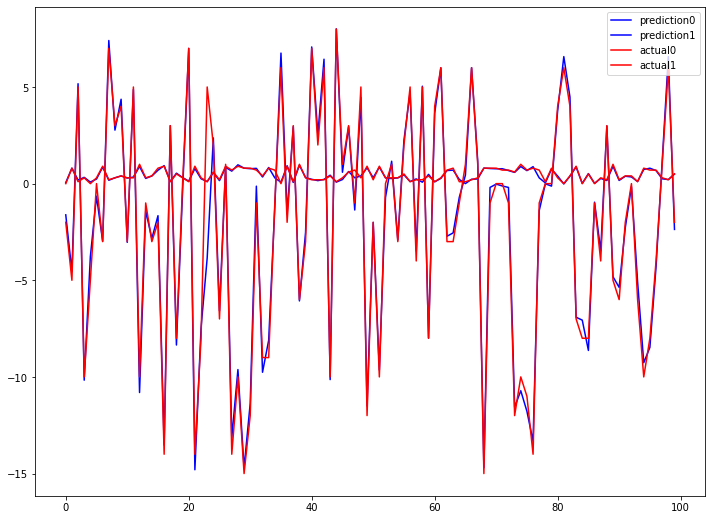

In [11]:

plt.figure(figsize=(12, 9))
plt.plot(pred0[:100],'blue',label='prediction0')
plt.plot(pred1[:100],'blue',label='prediction1')
plt.plot(actual0[:100],'red',label='actual0')
plt.plot(actual1[:100],'red',label='actual1')
plt.legend(loc='upper right')
plt.show()